# Viking20x Labrador Sea water mass budget


### Figures 12 and 13 for paper.

- reads in section data produced on GEOMAR JupyterLab
- plots the section data
- calculates densities
- budget in density space

In [337]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import cmocean as co 
from xhistogram.xarray import histogram
import seawater as sw
from scipy import signal


import importlib
import sys

In [338]:
# path to some plotting routines
sys.path.append(r'../../src/')

In [339]:
import xorca_brokenline as bl
from xorca_lonlat2ij import get_ij

In [340]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

In [341]:
def butter_lowpass(cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = signal.sosfiltfilt(sos, data,padtype='even',padlen=50)
    return y

In [342]:
def lowpass_filter(timser):
    timser_mean = timser.mean()
    timser_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, timser-timser_mean,cutoff,fs,
                     dask='parallelized')
    return timser_filtered + timser_mean


In [197]:
fs = 73.0  #samples per year
cutoff = 0.677


### Set up paths and read in data

In [87]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

input_section_data_path = Path('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/')
input_flux_data_path = Path('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/surfaceFluxes/')
input_vol_data_path = Path('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/')

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

# output figures path
figure_path = Path("reports/figures/coldBlob/final/")


In [9]:
data_section_osnap = list(sorted(Path(input_section_data_path).glob(f"*OSNAP_5d*.nc/")))
data_section_davis = list(sorted(Path(input_section_data_path).glob(f"*DAVIS_5d*.nc/")))
data_section_hudso = list(sorted(Path(input_section_data_path).glob(f"*HUDSN_5d*.nc/")))


In [10]:
print(data_section_osnap)
print(data_section_davis)
print(data_section_hudso)

[PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1990.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1991.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1992.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1993.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1994.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1995.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1996.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/sections/sectionOSNAP_5d_1997.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_

In [13]:
section_osnap = xr.concat(
    [xr.open_dataset(store) for store in data_section_osnap],
    dim="time_counter",
)

display(section_osnap)

<xarray.Dataset>
Dimensions:       (c: 1280, z: 46, time_counter: 2190)
Coordinates:
  * c             (c) float64 3.502e+03 7.005e+03 ... 4.225e+06 4.229e+06
  * z             (z) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
Data variables: (12/14)
    u_normal      (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    tau_normal    (time_counter, c) float64 nan nan nan nan ... nan nan nan nan
    u_along       (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    tau_along     (time_counter, c) float64 nan nan nan nan ... nan nan nan nan
    votemper      (time_counter, z, c) float32 nan nan nan nan ... nan nan nan
    vosaline      (time_counter, z, c) float32 nan nan nan nan ... nan nan nan
    ...            ...
    jj            (time_counter, c) int64 9 9 9 9 9 10 ... 143 143 143 143 143
    dx            (time_counter, c) float64 3.502e+03 3.502e+03 ... 3.361e+03
    lat           (time_counter, c) float32 52.08 52.08 52.08 ... 56.74 56.74
    lon           (time_counter, c) float32 -56.13 -56.08 ... -5.839 -5.785
    dz            (time_counter, z, c) float64 6.191 6.191 6.191 ... 250.4 250.4
    mask          (time_counter, z, c) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [14]:
section_davis = xr.concat(
    [xr.open_dataset(store) for store in data_section_davis],
    dim="time_counter",
)

display(section_davis)

<xarray.Dataset>
Dimensions:       (c: 300, z: 46, time_counter: 2190)
Coordinates:
  * c             (c) float64 2.566e+03 5.133e+03 ... 7.856e+05 7.883e+05
  * z             (z) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
Data variables: (12/14)
    u_normal      (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    tau_normal    (time_counter, c) float64 nan nan nan nan ... nan nan nan nan
    u_along       (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    tau_along     (time_counter, c) float64 nan nan nan nan ... nan nan nan nan
    votemper      (time_counter, z, c) float32 nan nan nan nan ... nan nan nan
    vosaline      (time_counter, z, c) float32 nan nan nan nan ... nan nan nan
    ...            ...
    jj            (time_counter, c) int64 96 96 96 96 96 96 ... 96 96 96 96 96
    dx            (time_counter, c) float64 2.566e+03 2.567e+03 ... 2.685e+03
    lat           (time_counter, c) float32 64.95 64.96 64.97 ... 67.58 67.58
    lon           (time_counter, c) float32 -69.05 -69.0 ... -52.78 -52.72
    dz            (time_counter, z, c) float64 6.191 6.191 6.191 ... 250.4 250.4
    mask          (time_counter, z, c) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [15]:
section_hudso = xr.concat(
    [xr.open_dataset(store) for store in data_section_hudso],
    dim="time_counter",
)

display(section_hudso)

<xarray.Dataset>
Dimensions:       (c: 498, z: 46, time_counter: 2190)
Coordinates:
  * c             (c) float64 3.138e+03 6.275e+03 ... 1.374e+06 1.376e+06
  * z             (z) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
Data variables: (12/14)
    u_normal      (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    tau_normal    (time_counter, c) float64 nan nan nan nan ... nan nan nan nan
    u_along       (time_counter, z, c) float64 nan nan nan nan ... nan nan nan
    tau_along     (time_counter, c) float64 nan nan nan nan ... nan nan nan nan
    votemper      (time_counter, z, c) float32 nan nan nan nan ... nan nan nan
    vosaline      (time_counter, z, c) float32 nan nan nan nan ... nan nan nan
    ...            ...
    jj            (time_counter, c) int64 100 101 102 103 ... 594 595 596 597
    dx            (time_counter, c) float64 3.138e+03 3.137e+03 ... 2.473e+03
    lat           (time_counter, c) float32 52.62 52.64 52.67 ... 64.45 64.47
    lon           (time_counter, c) float32 -64.99 -65.0 ... -71.54 -71.57
    dz            (time_counter, z, c) float64 6.191 6.191 6.191 ... 250.4 250.4
    mask          (time_counter, z, c) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [16]:
# only want osnap w here
section_osnap = section_osnap.isel(c=slice(0,500,1))

# fix section ii,jj indices

section_osnap['ii'] = section_osnap.ii + 850
section_osnap['jj'] = section_osnap.jj + 1950
section_davis['ii'] = section_davis.ii + 650
section_davis['jj'] = section_davis.jj + 2400
section_hudso['ii'] = section_hudso.ii + 650
section_hudso['jj'] = section_hudso.jj + 1900



# add some missing attributes, mostly for automatic axis labels
# there is presumably a neater way to do this with a dictionary

section_osnap.vosaline.attrs['long_name']='salinity'
section_osnap.vosaline.attrs['units']='PSU'
section_osnap.votemper.attrs['long_name']='potential temperature'
section_osnap.votemper.attrs['units']='$\degree C$'
section_osnap.c.attrs['long_name']='Distance'
section_osnap.c.attrs['units']='m'
section_osnap.z.attrs['long_name']='Depth'
section_osnap.z.attrs['units']='m'
section_osnap.time_counter.attrs["long_name"] = 'Time'

section_davis.vosaline.attrs['long_name']='salinity'
section_davis.vosaline.attrs['units']='PSU'
section_davis.votemper.attrs['long_name']='potential temperature'
section_davis.votemper.attrs['units']='$\degree C$'
section_davis.c.attrs['long_name']='Distance'
section_davis.c.attrs['units']='m'
section_davis.z.attrs['long_name']='Depth'
section_davis.z.attrs['units']='m'
section_davis.time_counter.attrs["long_name"] = 'Time'

section_hudso.vosaline.attrs['long_name']='salinity'
section_hudso.vosaline.attrs['units']='PSU'
section_hudso.votemper.attrs['long_name']='potential temperature'
section_hudso.votemper.attrs['units']='$\degree C$'
section_hudso.c.attrs['long_name']='Distance'
section_hudso.c.attrs['units']='m'
section_hudso.z.attrs['long_name']='Depth'
section_hudso.z.attrs['units']='m'
section_hudso.time_counter.attrs["long_name"] = 'Time'

### add sigma-0 to section datafile

In [17]:
# osnap
S = section_osnap.vosaline.data
T = section_osnap.votemper.data
sig0 = sw.pden(S,T,0.0,0.0)
sig0 -= 1000.0
section_osnap = section_osnap.assign({"vosigma0":(("time_counter", "z", "c"),sig0)})
#davis strait
S = section_davis.vosaline.data
T = section_davis.votemper.data
sig0 = sw.pden(S,T,0.0,0.0)
sig0 -= 1000.0
section_davis = section_davis.assign({"vosigma0":(("time_counter", "z", "c"),sig0)})
#hudson bay
S = section_hudso.vosaline.data
T = section_hudso.votemper.data
sig0 = sw.pden(S,T,0.0,0.0)
sig0 -= 1000.0
section_hudso = section_hudso.assign({"vosigma0":(("time_counter", "z", "c"),sig0)})


### calculate transports into labrador sea

resulting arrays hold volume, heat and freshwater transports

reference salinity can be supplied S_ref (default 34.8).

In [18]:
transport_osnapw = bl.calculate_transport(section_osnap,S_ref=34.92)
transport_daviss = bl.calculate_transport(section_davis,S_ref=34.92)
transport_hudson = bl.calculate_transport(section_hudso,S_ref=34.92)

transport_osnapw.trsp.attrs["long_name"] = 'volume transport'
transport_osnapw.trsp.attrs["units"] = 'Sv'
transport_daviss.trsp.attrs["long_name"] = 'volume transport'
transport_daviss.trsp.attrs["units"] = 'Sv'
transport_hudson.trsp.attrs["long_name"] = 'volume transport'
transport_hudson.trsp.attrs["units"] = 'Sv'

transport_osnapw.ht_trsp.attrs["long_name"] = 'heat transport'
transport_osnapw.ht_trsp.attrs["units"] = 'W'
transport_daviss.ht_trsp.attrs["long_name"] = 'heat transport'
transport_daviss.ht_trsp.attrs["units"] = 'W'
transport_hudson.ht_trsp.attrs["long_name"] = 'heat transport'
transport_hudson.ht_trsp.attrs["units"] = 'W'

transport_osnapw.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_osnapw.fw_trsp.attrs["units"] = 'Sv'
transport_daviss.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_daviss.fw_trsp.attrs["units"] = 'Sv'
transport_hudson.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_hudson.fw_trsp.attrs["units"] = 'Sv'


## calculate overturning streamfunction

In [71]:
def calculate_amoc(section2):
    """ Calculate transports binned on sigma layers

    Parameters
    ----------
    section: xarray.Dataset
        Dataset returned by broken_line.section() with vosigma0 added
  
    Returns
    -------
    trsp : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins

    """
    deltarho = 0.01
    
    sigbins = np.arange(10,28.0001, deltarho)

    # Volume transport
    trsp = section2['u_normal'] * section2['dx'] * section2['dz'] / 1e06
    
    trsp_sigma = histogram(section2.vosigma0, bins=[sigbins], dim=["z","c"], weights=trsp)
    trsp_sigma["vosigma0_bin"] = sigbins[1:None]
    trsp_sigma.attrs["long_name"]='MOC'
    trsp_sigma.vosigma0_bin.attrs["long_name"]= '$\sigma_0$'
    trsp_sigma.time_counter.attrs["long_name"]= "Date"
    trsp_sigma.vosigma0_bin.attrs["units"]= r'$\mathrm{kg\,m^{-3}}$'
    trsp_sigma.attrs["units"]='Sv'
    
    return trsp_sigma

In [72]:
amoc_osnap = calculate_amoc(section_osnap)
amoc_davis = calculate_amoc(section_davis)
amoc_hudso = calculate_amoc(section_hudso)


In [73]:
amoc_davis

<xarray.DataArray 'histogram_vosigma0' (time_counter: 2190, vosigma0_bin: 1800)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
  * vosigma0_bin  (vosigma0_bin) float64 10.01 10.02 10.03 ... 27.98 27.99 28.0
Attributes:
    long_name:  MOC
    units:      Sv

In [74]:
    # sum from low to high density

amoc_osnap_sumup=amoc_osnap.cumsum(dim="vosigma0_bin")
amoc_davis_sumup=amoc_davis.cumsum(dim="vosigma0_bin")
amoc_hudso_sumup=amoc_hudso.cumsum(dim="vosigma0_bin")

                    

### some labrador current calculations

In [75]:
amoc_osnap_lss = calculate_amoc(section_osnap.isel(c=slice(  0,250,1)))
amoc_osnap_lss_sumup=amoc_osnap_lss.cumsum(dim="vosigma0_bin")
amoc_osnap_lss_annualmean = amoc_osnap_lss.groupby(amoc_osnap_lss.time_counter.dt.year).mean()
amoc_osnap_lss_sumup_annualmean = amoc_osnap_lss_sumup.groupby(amoc_osnap_lss_sumup.time_counter.dt.year).mean()

amoc_osnap_lsn = calculate_amoc(section_osnap.isel(c=slice(250,None,1)))
amoc_osnap_lsn_sumup=amoc_osnap_lsn.cumsum(dim="vosigma0_bin")
amoc_osnap_lsn_annualmean = amoc_osnap_lsn.groupby(amoc_osnap_lsn.time_counter.dt.year).mean()
amoc_osnap_lsn_sumup_annualmean = amoc_osnap_lsn_sumup.groupby(amoc_osnap_lsn_sumup.time_counter.dt.year).mean()

amoc_osnap_annualmean = amoc_osnap.groupby(amoc_osnap.time_counter.dt.year).mean()
amoc_osnap_sumup_annualmean = amoc_osnap_sumup.groupby(amoc_osnap_sumup.time_counter.dt.year).mean()
amoc_davis_annualmean = amoc_davis.groupby(amoc_davis.time_counter.dt.year).mean()
amoc_davis_sumup_annualmean = amoc_davis_sumup.groupby(amoc_davis_sumup.time_counter.dt.year).mean()
amoc_hudso_annualmean = amoc_hudso.groupby(amoc_hudso.time_counter.dt.year).mean()
amoc_hudso_sumup_annualmean = amoc_hudso_sumup.groupby(amoc_hudso_sumup.time_counter.dt.year).mean()


## Read in heat and freshwater flux terms

In [76]:
data_heat_flux_sigma = list(sorted(Path(input_flux_data_path).glob(f"*heat_flux_sigma_5d*.nc/")))
data_freshwater_flux_sigma = list(sorted(Path(input_flux_data_path).glob(f"*freshwater_flux_sigma_5d*.nc/")))

In [81]:
heat_flux_sigma = xr.concat(
    [xr.open_dataarray(store) for store in data_heat_flux_sigma],
    dim="time_counter",
).squeeze()

display(heat_flux_sigma)

<xarray.DataArray 'histogram_sosigma0' (time_counter: 2190, sosigma0_bin: 1800)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
  * sosigma0_bin  (sosigma0_bin) float64 10.01 10.02 10.03 ... 27.98 27.99 28.0
Attributes:
    long_name:  volume flux
    units:      Sv

In [82]:
freshwater_flux_sigma = xr.concat(
    [xr.open_dataarray(store) for store in data_freshwater_flux_sigma],
    dim="time_counter",
).squeeze()

display(freshwater_flux_sigma)

<xarray.DataArray 'histogram_sosigma0' (time_counter: 2190, sosigma0_bin: 1800)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.00570611,
        -0.00570611, -0.00570611],
       [ 0.        ,  0.        ,  0.        , ...,  0.02563211,
         0.02563211,  0.02563211],
       [ 0.        ,  0.        ,  0.        , ...,  0.00972185,
         0.00972185,  0.00972185],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.01029258,
         0.01029258,  0.01029258],
       [ 0.        ,  0.        ,  0.        , ...,  0.01013176,
         0.01013176,  0.01013176],
       [ 0.        ,  0.        ,  0.        , ...,  0.02588349,
         0.02588349,  0.02588349]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
  * sosigma0_bin  (sosigma0_bin) float64 10.01 10.02 10.03 ... 27.98 27.99 28.0
Attributes:
    long_name:  volume flux
    units:      Sv

In [83]:
heat_flux_sigma=heat_flux_sigma.rename({'sosigma0_bin':'vosigma0_bin'})
freshwater_flux_sigma=freshwater_flux_sigma.rename({'sosigma0_bin':'vosigma0_bin'})


In [84]:
heat_flux_sigma_annualmean = heat_flux_sigma.groupby(heat_flux_sigma.time_counter.dt.year).mean()
freshwater_flux_sigma_annualmean = freshwater_flux_sigma.groupby(freshwater_flux_sigma.time_counter.dt.year).mean()


## Read in volume tendency terms

In [90]:
data_vol_sigma = list(sorted(Path(input_vol_data_path).glob(f"*volume_by_sigma_5d*.nc/")))


In [91]:
data_vol_sigma

[PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/volume_by_sigma_5d_1990.nc'),
 PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/volume_by_sigma_5d_1991.nc'),
 PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/volume_by_sigma_5d_1992.nc'),
 PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/volume_by_sigma_5d_1993.nc'),
 PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/volume_by_sigma_5d_1994.nc'),
 PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/volume_by_sigma_5d_1995.nc'),
 PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/watermassBudget/volumeBudget/volume_by_sigma_5d_1996.nc'),
 Posix

In [97]:
volume_by_sigma = xr.concat(
    [xr.open_dataarray(store) for store in data_vol_sigma],
    dim="time_counter",
).squeeze()

# set vosigma0_bin to upper bin boundaries (rather than centres)
volume_by_sigma["vosigma0_bin"] = heat_flux_sigma["vosigma0_bin"] 

display(volume_by_sigma)

<xarray.DataArray 'histogram_vosigma0' (time_counter: 2190, vosigma0_bin: 1800)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
  * vosigma0_bin  (vosigma0_bin) float64 10.01 10.02 10.03 ... 27.98 27.99 28.0
Attributes:
    long_name:  volume
    units:      m$^3$

In [116]:
dVbydt = volume_by_sigma.rolling(time_counter=2).mean()

In [117]:
dVbydt = dVbydt.diff(dim='time_counter',n=1,label='lower')

In [118]:
dVbydt

<xarray.DataArray 'histogram_vosigma0' (time_counter: 2189, vosigma0_bin: 1800)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
  * vosigma0_bin  (vosigma0_bin) float64 10.01 10.02 10.03 ... 27.98 27.99 28.0
Attributes:
    long_name:  volume
    units:      m$^3$

In [119]:
dVbydt = dVbydt / (1.0e06* 24.0 * 3600.0*5)

In [120]:
dVbydt

<xarray.DataArray 'histogram_vosigma0' (time_counter: 2189, vosigma0_bin: 1800)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1990-01-03T12:00:00 ... 2019-...
  * vosigma0_bin  (vosigma0_bin) float64 10.01 10.02 10.03 ... 27.98 27.99 28.0
Attributes:
    long_name:  volume
    units:      m$^3$

#### accumulate from minimum density to give volume flux across isopycnal towards lower density

In [121]:
dVbydt_sigma = dVbydt.cumsum(dim='vosigma0_bin')

In [122]:
dVbydt_sigma_annualmean = dVbydt_sigma.groupby(dVbydt_sigma.time_counter.dt.year).mean()

## Plot some time series to find out what is happening

#### start with sigma0 = 27.62 kg m$^{-3}$

In [151]:
sigref = 10.0
sigsel = 27.65

isigsel = int((sigsel - sigref) * 100.0)

heat_flux_sigma.vosigma0_bin[isigsel]

<xarray.DataArray 'vosigma0_bin' ()>
array(27.65)
Coordinates:
    vosigma0_bin  float64 27.65
Attributes:
    long_name:  $ \sigma _\theta $
    units:      kg m$^{-3}$

In [289]:
labcu_sum_sourcetime = xr.open_dataset('labcu_sum_sourcetime_normalize.nc')

In [303]:
test = labcu_sum_sourcetime.vol_trans_normal/labcu_sum_sourcetime.normalize_curve

In [373]:
rolling = xr.apply_ufunc(butter_lowpass_filtfilt, labcu_sum_sourcetime.vol_trans_normal,cutoff,fs,
                         dask='parallelized')    


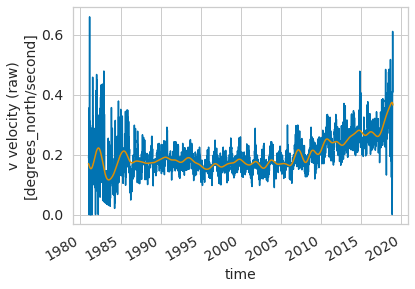

In [384]:
test.isel(subsetno=0).isel(time=slice(73,-73,1)).plot()
(rolling.isel(subsetno=0)/labcu_sum_sourcetime.normalize_curve).isel(time=slice(73,-73,1)).plot()


In [377]:
labcu_sum_sourcetime.normalize_curve

<xarray.DataArray 'normalize_curve' (time: 2922)>
array([-1.387779e-17,  1.112990e-04,  2.140711e-04, ...,  0.000000e+00,
        0.000000e+00,  0.000000e+00])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-03T12:00:00 ... 2019-12-29T12:00:00

In [477]:
def plot_line_with_errorbars(ds,timeslice,roll,ax,colour,linestyle='--',label=''):

    rolling = xr.apply_ufunc(butter_lowpass_filtfilt, ds ,cutoff,fs,
                         dask='parallelized').vol_trans_normal/ds.normalize_curve
    std = ((32*rolling).std(dim='subsetno'))
    mean = (32*rolling).mean(dim='subsetno')
    mean.isel(time=timeslice).plot(ax=ax,color=colour,zorder=10,label=label,linewidth=2,linestyle=linestyle)
    ax.fill_between(ds.isel(time=timeslice).time.data,
                    mean.isel(time=timeslice)+1.96*std.isel(time=timeslice),
                    mean.isel(time=timeslice)-1.96*std.isel(time=timeslice),
                    color=colour,zorder=1,alpha=0.5,linewidth=0)
    return


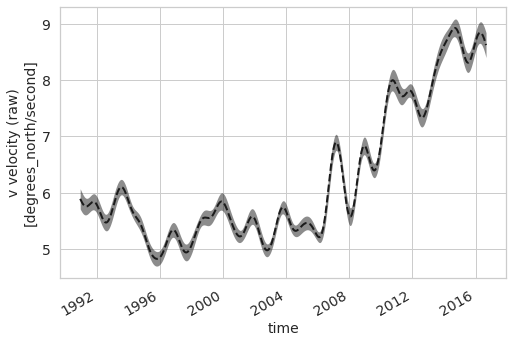

In [478]:
fig,ax = plt.subplots(1,1,figsize = (8,5), sharex=True)
plot_line_with_errorbars(labcu_sum_sourcetime,slice(800,2679,1),73,ax,'k',label='Labrador Sea')


In [482]:
def plot_time_series_filtered(fxs,colors,labels,title,labcu_sum_sourcetime):
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")
    plt.rc('font', size=14) #controls default text size
    plt.rc('axes', titlesize=14) #fontsize of the title
    plt.rc('axes', labelsize=14) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
    plt.rc('legend', fontsize=14) #fontsize of the legend
    plt.rc('savefig', dpi=300)       # higher res outputs
    

    fxs_mean = [fx.mean() for fx in fxs]
    fxs_filtered = [xr.apply_ufunc(butter_lowpass_filtfilt, fx,cutoff,fs,
                         dask='parallelized') for fx in fxs]

    fig,ax = plt.subplots(2,1,figsize=(8,6),sharex=True)
    plt.tight_layout()

#     for ii,curve in enumerate(zip(fxs[3:None],colors[3:None],labels[3:None])):
#         curve[0].plot(ax=ax[0],color=curve[1],zorder=10-ii,linewidth = 1,alpha=0.5)
    for ii,curve in enumerate(zip(fxs_filtered[3:None],colors[3:None],labels[3:None])):
        curve[0].isel(time_counter=slice(73,-73,1)).plot(ax=ax[0],color=curve[1],label=curve[2],zorder=10-ii,linewidth = 2)

#     for ii,curve in enumerate(zip(fxs[0:4],colors[0:4],labels[0:4])):
#         curve[0].plot(ax=ax[1],color=curve[1],zorder=10-ii,linewidth = 1,alpha=0.5)
    for ii,curve in enumerate(zip(fxs_filtered[0:4],colors[0:4],labels[0:4])):
        curve[0].isel(time_counter=slice(73,-73,1)).plot(ax=ax[1],color=curve[1],label=curve[2],zorder=10-ii,linewidth = 2)

    ax2 = ax[0].twinx() 
    plot_line_with_errorbars(labcu_sum_sourcetime,slice(800,2500,1),73,ax2,'k',label='Labrador Sea')


    # ax.set_ylim(bottom=0) 
    ax[0].set_xlabel('')
    ax[0].set_ylabel('volume flux [Sv]')
    ax[0].set_title('')
#     ax[0].legend()
    ax[0].set_ylim(bottom=0,top=25)
    ax2.set_xlabel('')
    ax2.set_ylabel('particle tracking\nvolume transport [Sv]')
    ax2.set_ylim(bottom=0,top=20)

    
    # ax.set_ylim(bottom=0) 
    ax[1].set_xlabel('')
    ax[1].set_ylabel('volume flux [Sv]')
    ax[1].set_title('')
#     ax[1].legend()
    ax[1].set_ylim(bottom=-10)


# a bit of a bodge to label the curves    
    ax[0].text(0.75, 0.09, labels[3], horizontalalignment='left',transform=ax[0].transAxes,color=colors[3])
    ax[0].text(0.4, 0.75, labels[4], horizontalalignment='left',transform=ax[0].transAxes,color=colors[4])
    ax[0].text(0.55, 0.45, labels[5], horizontalalignment='left',transform=ax[0].transAxes,color=colors[5])
    ax[0].text(0.3, 0.13, 'tracked to OSNAP$_{\mathrm{E}}$', horizontalalignment='left',transform=ax[0].transAxes,color='k')

    ax[1].text(0.4, 0.6, labels[0], horizontalalignment='left',transform=ax[1].transAxes,color=colors[0])
    ax[1].text(0.6, 0.05, labels[1], horizontalalignment='left',transform=ax[1].transAxes,color=colors[1])
    ax[1].text(0.45, 0.3, labels[2], horizontalalignment='left',transform=ax[1].transAxes,color=colors[2])
    ax[1].text(0.6, 0.9, labels[3], horizontalalignment='left',transform=ax[1].transAxes,color=colors[3])

    ax[0].text(0.01, 0.9, '(a)', horizontalalignment='left',transform=ax[0].transAxes,color='k')
    ax[1].text(0.01, 0.9, '(b)', horizontalalignment='left',transform=ax[1].transAxes,color='k')
    
    
    
    plt.savefig(project_path / figure_path / 'f13.png',dpi=300, bbox_inches='tight')
    plt.savefig(project_path / figure_path / 'f13.pdf',dpi=300, bbox_inches='tight')
    
    return
    

In [483]:
tot_inflow = (amoc_osnap_lsn_sumup-
                  amoc_davis_sumup-
                  amoc_hudso_sumup)
net_inflow = (amoc_osnap_sumup-
                  amoc_davis_sumup-
                  amoc_hudso_sumup)
net_mixing = (net_inflow - 
              heat_flux_sigma -
              freshwater_flux_sigma - 
              dVbydt_sigma)


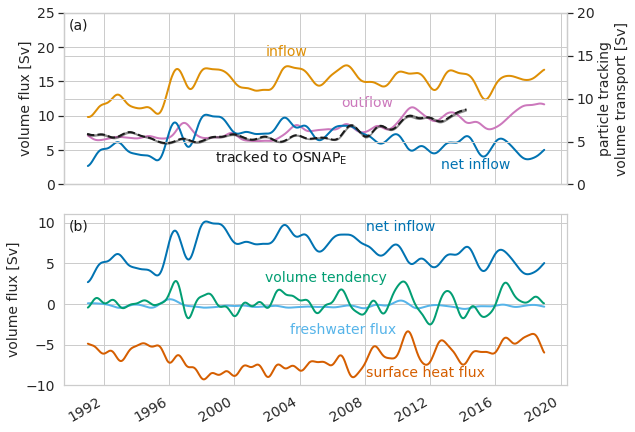

In [484]:
plot_time_series_filtered([
    dVbydt_sigma.isel(vosigma0_bin=isigsel),
                  -heat_flux_sigma.isel(vosigma0_bin=isigsel),
                  -freshwater_flux_sigma.isel(vosigma0_bin=isigsel),
                  net_inflow.isel(vosigma0_bin=isigsel),
                  tot_inflow.isel(vosigma0_bin=isigsel),
                  -amoc_osnap_lss_sumup.isel(vosigma0_bin=isigsel),
                 ],
                 ['C2','C3','C9','C0','C1','C4'],
                 ['volume tendency','surface heat flux','freshwater flux','net inflow','inflow','outflow'],
                 'watermass balance 27.68',labcu_sum_sourcetime)

In [444]:
def plot_amoc_lc_mean_and_var(osnap,
                              davis,
                              hudso,
                              heatf,
                              fresh,
                              dVbdt,
                              title_text):
    sns.set(style="whitegrid")
    sns.set_palette("colorblind",10)
    fig, ax = plt.subplots(2,1,figsize=(5,8),gridspec_kw={'hspace': 0.01,'height_ratios': [1, 4]},sharex=True,dpi=100)
    plt.tight_layout()

    mixin = osnap-davis-hudso-heatf-fresh-dVbdt
    totin = osnap-davis-hudso
    
    
# split plot vertically to emphasise the higher density levels
    stdd_osnap = osnap.std(dim='year')
    mean_osnap = osnap.mean(dim='year')
    stdd_davis = davis.std(dim='year')
    mean_davis = davis.mean(dim='year')
    stdd_hudso = hudso.std(dim='year')
    mean_hudso = hudso.mean(dim='year')
    stdd_heatf = heatf.std(dim='year')
    mean_heatf = -heatf.mean(dim='year')
    stdd_fresh = fresh.std(dim='year')
    mean_fresh = -fresh.mean(dim='year')
    stdd_dVbdt = dVbdt.std(dim='year')
    mean_dVbdt = dVbdt.mean(dim='year')
    stdd_mixin = mixin.std(dim='year')
    mean_mixin = -mixin.mean(dim='year')
    stdd_totin = totin.std(dim='year')
    mean_totin = totin.mean(dim='year')

# lower density section
    
    (mean_totin.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C0',label='net inflow'))
    ax[0].fill_betweenx(stdd_totin.vosigma0_bin,mean_totin+stdd_totin,mean_totin-stdd_totin,zorder=1,alpha=0.5,linewidth=0,color='C0')
#     (mean_osnap.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_osnap.vosigma0_bin,mean_osnap+stdd_osnap,mean_osnap-stdd_osnap,zorder=1,alpha=0.5,linewidth=0)
#     (mean_davis.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_davis.vosigma0_bin,mean_davis+stdd_davis,mean_davis-stdd_davis,zorder=1,alpha=0.5,linewidth=0)
#     (mean_hudso.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[0].fill_betweenx(stdd_hudso.vosigma0_bin,mean_hudso+stdd_hudso,mean_hudso-stdd_hudso,zorder=1,alpha=0.5,linewidth=0)
    (mean_heatf.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C3',label='surface\nheat flux'))
    ax[0].fill_betweenx(stdd_heatf.vosigma0_bin,mean_heatf+stdd_heatf,mean_heatf-stdd_heatf,zorder=1,alpha=0.5,linewidth=0,color='C3')
    (mean_fresh.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C9',label='surface\nfreshwater flux'))
    ax[0].fill_betweenx(stdd_fresh.vosigma0_bin,mean_fresh+stdd_fresh,mean_fresh-stdd_fresh,zorder=1,alpha=0.5,linewidth=0,color='C9')
    (mean_dVbdt.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C2',label='volume change'))
    ax[0].fill_betweenx(stdd_dVbdt.vosigma0_bin,mean_dVbdt+stdd_dVbdt,mean_dVbdt-stdd_dVbdt,zorder=1,alpha=0.5,linewidth=0,color='C2')
    (mean_mixin.plot.line(ax=ax[0],y="vosigma0_bin",add_legend=False,linewidth=2,color='C7',label='mixing'))
    ax[0].fill_betweenx(stdd_mixin.vosigma0_bin,mean_mixin+stdd_mixin,mean_mixin-stdd_mixin,zorder=1,alpha=0.5,linewidth=0,color='C7')

# higher density section
    (mean_totin.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C0',label='net inflow',zorder=10))
    ax[1].fill_betweenx(stdd_totin.vosigma0_bin,mean_totin+stdd_totin,mean_totin-stdd_totin,zorder=10,alpha=0.5,linewidth=0,color='C0')
#     (mean_osnap.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_osnap.vosigma0_bin,mean_osnap+stdd_osnap,mean_osnap-stdd_osnap,zorder=1,alpha=0.5,linewidth=0)
#     (mean_davis.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_davis.vosigma0_bin,mean_davis+stdd_davis,mean_davis-stdd_davis,zorder=1,alpha=0.5,linewidth=0)
#     (mean_hudso.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=1.4))
#     ax[1].fill_betweenx(stdd_hudso.vosigma0_bin,mean_hudso+stdd_hudso,mean_hudso-stdd_hudso,zorder=1,alpha=0.5,linewidth=0)
    (mean_heatf.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C3',label='surface\nheat flux',zorder=9))
    ax[1].fill_betweenx(stdd_heatf.vosigma0_bin,mean_heatf+stdd_heatf,mean_heatf-stdd_heatf,zorder=9,alpha=0.5,linewidth=0,color='C3')
    (mean_fresh.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C9',label='surface\nfreshwater flux',zorder=8))
    ax[1].fill_betweenx(stdd_fresh.vosigma0_bin,mean_fresh+stdd_fresh,mean_fresh-stdd_fresh,zorder=8,alpha=0.5,linewidth=0,color='C9')
    (mean_dVbdt.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C2',label='volume change',zorder=7))
    ax[1].fill_betweenx(stdd_dVbdt.vosigma0_bin,mean_dVbdt+stdd_dVbdt,mean_dVbdt-stdd_dVbdt,zorder=7,alpha=0.5,linewidth=0,color='C2')
    (mean_mixin.plot.line(ax=ax[1],y="vosigma0_bin",add_legend=False,linewidth=2,color='C7',label='mixing',zorder=6))
    ax[1].fill_betweenx(stdd_mixin.vosigma0_bin,mean_mixin+stdd_mixin,mean_mixin-stdd_mixin,zorder=6,alpha=0.5,linewidth=0,color='C7')

# set up axes
    ax[0].set_ylim([26.99,20])
#     ax[0].set_xlim([-1,1])
#     ax[0].set_title(title_text)

    ax[1].set_ylim([28,27])
#     ax[1].set_xlim([-1,1])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()
        
    ax[1].set_xlabel('volume transformation [Sv]')
        
    lgd = ax[1].legend(loc='upper right', bbox_to_anchor=(1.01, 1.27))

    plt.savefig(project_path / figure_path / 'f12.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / 'f12.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    return

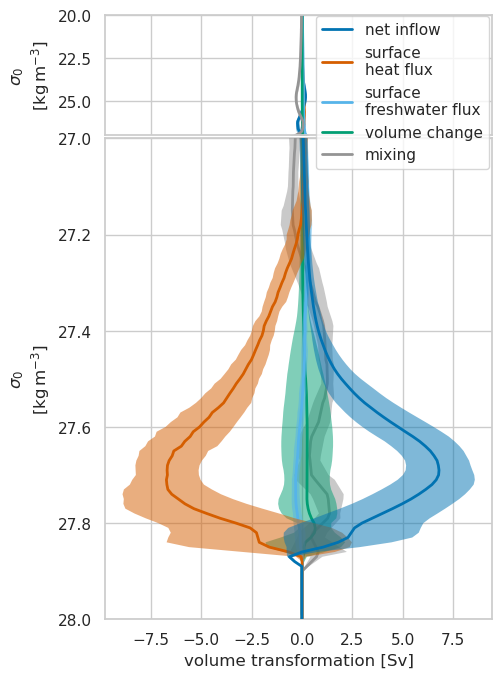

In [445]:
plot_amoc_lc_mean_and_var(amoc_osnap_sumup_annualmean,
                          amoc_davis_sumup_annualmean,
                          amoc_hudso_sumup_annualmean,
                          heat_flux_sigma_annualmean,
                          freshwater_flux_sigma_annualmean,
                          dVbydt_sigma_annualmean,'')